# Recommending Top Neighborhoods for Opening An Italian Restaurant in Manhattan, NYC

In order to find out which neighborhoods are ideal for opening an Italian restaurant in Manhattan, first a list of NYC neighborhoods and their coordinates is used to separate those for Manhattan. Then we will obtain information on restaurants and Italian restaurants, specifically, in each neighborhood. **We would ideally want to look at neighborhoods that have at least one restaurant, since we don't want to start a restaurant business where customers don't usually seek out for, but have the lowest density of Italian and other types of restaurants.** Then, using crime data from NYPD Complaint Data for 2018, we will determine the density of crimes that have happened in each neighborhood.

Our strategy for choosing the best neighborhoods for our purpose is, obviously, those with the lowest crime rates, lowest number of restaurants and Italian restaurants.

Let's import some of the libraries we will be needing during the course of this project.

In [1]:
import requests
import pandas as pd 
import numpy as np 
import random 

# module to convert an address into latitude and longitude values
from geopy.geocoders import Nominatim 

### Not show warnings about the Python libraries
import warnings
warnings.filterwarnings('ignore')


# Matplotlib and associated plotting modules
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

import json 

# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize


import re

### Library to parse HTML
from bs4 import BeautifulSoup 

#!conda install -c conda-forge folium=0.9.1 --yes
import folium

from sklearn.cluster import KMeans 

print('All libraries installed!')

All libraries installed!


## Datasets:

### 1. Coordinates and Names of Neighborhoods and Boroughs of NYC:

Next, we can obtain the New York neighborhood and borough dataset from the following like:
https://geo.nyu.edu/catalog/nyu_2451_34572

The dataset contains 5 boroughs, 306 neighborhoods in each borough, and the the latitude and logitude coordinates of each neighborhood.

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


We use `load` method from `json` module to read the newyork_data.json file:

In [3]:
with open('newyork_data.json') as json_data:
    ny_data = json.load(json_data)

Let's see how we can extract the information we are looking for; i.e. boruoughs and their respective neighborhoods, latitudes and longitudes.

The neighborhood information that we need exists in `features` key...

In [4]:
ny_neighbors = ny_data['features']

Looking at the first instance from `ny_neighbors`:

In [5]:
ny_neighbors[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

We need the coordinates of the neighborhood that is in `geometry.coordinates` that is a list of longitude and latitudes, its name from `properties.name`, and the borough it's in from `properties.borough`. Let's create a function that transforms ny_neighbors with these categories into a pandas dataframe, and let's call it `NY_df`:

In [6]:
def get_data(data_file):
    
    Column_names = ['Borough','Neighborhood','Latitude','Longitude']   
    ### Create an empty dataframe:
    df = pd.DataFrame(columns = Column_names)
    
    for item in data_file:
        Borough = item['properties']['borough']
        Neighborhood = item['properties']['name']
        Location = item['geometry']['coordinates']
        Latitude = Location[1]
        Longitude = Location[0]
    
        df = df.append({'Borough':Borough,'Neighborhood':Neighborhood,'Latitude':Latitude,'Longitude':Longitude},
                        ignore_index = True)
    return df

In [7]:
NY_df = get_data(ny_neighbors)

Let's check NY_df to see if it looks the way it should:

In [8]:
NY_df.head()

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

Great! Checking the number of neighborhoods and boroughs:

In [9]:
print('NY_df dataframe has {} neighborhoods and {} boroughs'.format(len(NY_df['Neighborhood'].unique()), 
                                                                   len(NY_df['Borough'].unique())))

NY_df dataframe has 302 neighborhoods and 5 boroughs


Let's visualize a map of NYC's neighborhoods using geopy library to get the coordinate values:

In [10]:
def folium_map(address, agent, color, fill_color, neighbor_style=None,df=None, 
               tiles=False, color_map=None, restaurant=None,geojson=None, borough=False, venue=False):
    geolocator = Nominatim(user_agent=agent)
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    
    if tiles:
        folium_map = folium.Map(location= [latitude,longitude], tiles='Mapbox bright',zoom_start=13)
        folium.TileLayer('CartoDB positron').add_to(folium_map)
    else:
        folium_map = folium.Map(location=[latitude, longitude], zoom_start=10)
        
    ### GeoJsonTooltip can extract specified field from "properties.properties":
    if geojson is not None:
        folium.GeoJson(geojson,style_function=neighbor_style, 
               name='geojson').add_to(folium_map).add_child(folium.features.GeoJsonTooltip(fields=('name',),
                      aliases = ['Neighborhood'],
                      labels=True, 
                      sticky=True))
    if df is not None:
        if borough:
            for lat, lng, bor, ngh in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
                label = '{}, {}'.format(ngh, bor)
                label = folium.Popup(label, parse_html=True)
                folium.CircleMarker(
                    [lat, lng],
                    radius=5,
                    popup=label,
                    color=color,
                    fill=True,
                    fill_color= fill_color,
                    fill_opacity=0.7,
                    parse_html=False).add_to(folium_map)
        elif venue:
            for lat, lng, ven,ngh,it in zip(df['Venue Latitude'],df['Venue Longitude'],df['Venue'],df['Neighborhood'],
                                   df['Venue Category']):
                i = neighborlist.index(ngh)
                if restaurant is not None:
                    rest = it=='{} Restaurant'.format(restaurant)
                    color = 'red' if rest else 'blue'
                label = '{}, {},{}'.format(ven,it,ngh)
                label = folium.Popup(label, parse_html=True)
                folium.CircleMarker(
                    [lat, lng],
                    radius=5,
                    popup=label,
                    color=color_map[i],
                    fill=True,
                    fill_color=color_map[i],
                    fill_opacity=0.6,
                    parse_html=False).add_to(folium_map) 
        elif restaurant is not None:
            for lat, lng, ven,it in zip(df['Venue Latitude'],df['Venue Longitude'],df['Venue'],
                                df['Venue Category']):
                label = '{}, {}'.format(ven,it)
                rest = it=='{} Restaurant'.format(restaurant)
                color = 'red' if rest else 'blue'
                label = folium.Popup(label, parse_html=True)
                folium.CircleMarker(
                    [lat, lng],
                    radius=5,
                    popup=label,
                    color=color,
                    fill=True,
                    fill_color=color,
                    fill_opacity=0.6,
                    parse_html=False).add_to(folium_map)  
        else:
            for lat, lng, ngh in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
                label = '{}'.format(ngh)
                label = folium.Popup(label, parse_html=True)
                folium.CircleMarker(
                    [lat, lng],
                    radius=5,
                    popup=label,
                    color=color,
                    fill=True,
                    fill_color= fill_color,
                    fill_opacity=0.7,
                    parse_html=False).add_to(folium_map)
    return display(folium_map)

In [11]:
folium_map('New York City, NY', 'nyc_neighborhoods', 'red', 'black', df = NY_df,borough=True)

Now, since we are focused on Manhattan only, we'll separate entries for Manhattan, and create a new DataFrame called NY_Manhattan:

In [12]:
def borough_dataframe(data, Borough):
    new_df = data[data['Borough']== Borough]
    new_df.reset_index(drop=True, inplace=True)
    new_df.drop('Borough', axis=1, inplace=True)
    return new_df

In [13]:
NY_Manhattan = borough_dataframe(NY_df, 'Manhattan')

Let's see how many Manhattan neighborhoods there are in the dataframe:

In [14]:
print('There are {} neighborhoods in Manhattan:{}'.format(len(NY_Manhattan['Neighborhood'].unique()),NY_Manhattan['Neighborhood'].unique()))

There are 40 neighborhoods in Manhattan:['Marble Hill' 'Chinatown' 'Washington Heights' 'Inwood'
 'Hamilton Heights' 'Manhattanville' 'Central Harlem' 'East Harlem'
 'Upper East Side' 'Yorkville' 'Lenox Hill' 'Roosevelt Island'
 'Upper West Side' 'Lincoln Square' 'Clinton' 'Midtown' 'Murray Hill'
 'Chelsea' 'Greenwich Village' 'East Village' 'Lower East Side' 'Tribeca'
 'Little Italy' 'Soho' 'West Village' 'Manhattan Valley'
 'Morningside Heights' 'Gramercy' 'Battery Park City' 'Financial District'
 'Carnegie Hill' 'Noho' 'Civic Center' 'Midtown South' 'Sutton Place'
 'Turtle Bay' 'Tudor City' 'Stuyvesant Town' 'Flatiron' 'Hudson Yards']


It seems that "Kips Bay" and "Two Bridges" neighborhoods are left out of the NY_Manhattan Dataframe. Let's add them:

In [15]:
def concat_df(dataframe, new_neighbors):
    df = pd.DataFrame(new_neighbors, columns=['Neighborhood', 'Latitude','Longitude'])
    dataframe = pd.concat([dataframe, df])
    dataframe.reset_index(drop=True, inplace=True)
    return dataframe

In [16]:
new_neighbors = [['Two Bridges','40.7117','-73.9944'], ['Kips Bay','40.7416','-73.9782']]
NY_Manhattan = concat_df(NY_Manhattan, new_neighbors)

In [17]:
NY_Manhattan.head()

Neighborhood Latitude Longitude
0         Marble Hill  40.8766  -73.9107
1           Chinatown  40.7156  -73.9943
2  Washington Heights  40.8519  -73.9369
3              Inwood  40.8677  -73.9212
4    Hamilton Heights  40.8236  -73.9497

Now we have coordinates of all 42 Manhattan neighborhoods.

In order to enhance the visualizations of different parameters in the coming sections, we need information on the border of each neighborhood. This is done using a `geojson` file that contains a dictionary of the name of each neighborhood along with the latitue and longitude coordinates of the edges of the respective neighborhood. However, these borders are somehow arbitrarily decided and there are discrepancies among the existing geojson files on the names of some neighborhoods and their borders. After going through all of them, and consulting with Google Maps and a number of other geojson files, I have created `Manhattan.Geo.Json` file for the 42 neighborhoods in the NY_Manhattan dataframe.

Let's read the json file and visualize the neighborhoods with folium:

In [18]:
with open('Manhattan.geo.json') as json_data:
    Manhattan_neighbor = json.load(json_data)

In [19]:
def mono_style(feature):
    return { 'color': 'blue', 'fill': True }

In [20]:
folium_map('Manhattan, NY','manhattan_NY','red','black',neighbor_style=mono_style,df=NY_Manhattan,
           tiles=True,geojson=Manhattan_neighbor)

From Manhattan_map we can see that the center of a number of neighborhoods are not quite within their borderlines. Let's update the centroid coordinates of neighborhoods so that we'd get the best results in the following sections. We will be using Python's `shapely` library. This library can read the coordinates of a Multipolygon, and implement various tasks on this data. Here, we will be using the `centroid` method to extract the centroid of each neighborhood multipolygon. The `wkt` method changes the shapely point coordinates of the centroids to readable text:

In [21]:
from shapely.geometry import shape

centers = []
for i in np.arange(len(NY_Manhattan)):
    for feature in Manhattan_neighbor['features']:
        polygon = shape(feature['geometry'])
        centers.append((feature['id'], polygon.centroid.wkt)) ## find the centroid of each multipolygon. 

We will define a function that can extract the latitude, longitude values of each neighborhood's centroid coordinate from the centers list:

In [22]:
def find_center(data):
    return re.findall('POINT \((.+)\)',data[1])[0].split(' ')

In [23]:
for ctr in centers:
    ind = NY_Manhattan.index[NY_Manhattan['Neighborhood']==ctr[0]].tolist()[0]
    NY_Manhattan.loc[ind,'Latitude'] = find_center(ctr)[1]
    NY_Manhattan.loc[ind,'Longitude'] = find_center(ctr)[0]

Finally, let's visualize the updated centroids to see all is in order:

In [24]:
folium_map('Manhattan, NY','manhattan_NY','red','black',neighbor_style=mono_style,df=NY_Manhattan,
           tiles=True,geojson=Manhattan_neighbor)

The map looks much better now! Excellent!

## 2. Venues in each Neighborhood

In the next step, we are going to use the Foursquare API to explore the neighborhoods and segment them. We will look for how many restaurants, and specifically, Italian restaurants there are in each neighborhood. The ideal place for a new Italian restaurant is within a neighborhood with fewer restaurants in total and Italian restaurants. We will extract 300 venues within the radius of 1000 m from the centroid of each neighborhood:

In [25]:
CLIENT_ID = 'EQJ3N3AKMI3XUQRA4T3PBGHFXW1UV1FBYUBSKB2KXHT0XPFQ'
CLIENT_SECRET =  '3D1FO0OBVSJWLBFS35RDRPYJBR2XEXTN32NMPNF1ZXOEZW0I'
VERSION = '20190605' # Foursquare API version

In [26]:
def get_Nearby_Venues(neighbors,lats, longs, radius=1000, LIMIT = 3000):
    
    venues_list=[]
    for neighbor, lat, lng in zip(neighbors, lats, longs):
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&intent={}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, 'browse',radius, LIMIT)
            
        # make the GET request
        nyc_json = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(neighbor, lat, lng, 
            t['venue']['name'], 
            t['venue']['location']['lat'], 
            t['venue']['location']['lng'],  
            t['venue']['categories'][0]['name']) for t in nyc_json])

    df_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    df_venues.columns = ['Neighborhood', 'Neighborhood Latitude', 
                  'Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    
    return(df_venues)

In [27]:
nyc_venues = get_Nearby_Venues(neighbors=NY_Manhattan['Neighborhood'],
                             lats = NY_Manhattan['Latitude'],longs = NY_Manhattan['Longitude'])

Let's save the results into a pandas DataFrame format:

In [28]:
nyc_venues.to_csv('manhattan_venues.csv', sep=',', encoding='UTF8')

Now, let's read `manhattan_venues.csv` into a pandas dataframe:

In [29]:
column_names = ['Neighborhood', 'Neighborhood Latitude', 
                'Neighborhood Longitude', 'Venue', 'Venue Latitude', 
                'Venue Longitude', 'Venue Category']
manhattan_venues = pd.read_csv('manhattan_venues.csv',index_col=0)

And as a precautionary measure, let's drop duplicate venues that may have overlapped across adjacent neighborhoods:

In [30]:
manhattan_venues.drop_duplicates(subset=['Venue','Venue Latitude','Venue Longitude','Venue Category'],keep='first',inplace=True)

In [31]:
manhattan_venues.reset_index(drop=True, inplace=True)
manhattan_venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude          Venue  \
0  Marble Hill              40.875959              -73.910384       Arturo's   
1  Marble Hill              40.875959              -73.910384    Bikram Yoga   
2  Marble Hill              40.875959              -73.910384    Sam's Pizza   
3  Marble Hill              40.875959              -73.910384  Tibbett Diner   
4  Marble Hill              40.875959              -73.910384      Starbucks   

   Venue Latitude  Venue Longitude Venue Category  
0       40.874412       -73.910271    Pizza Place  
1       40.876844       -73.906204    Yoga Studio  
2       40.879435       -73.905859    Pizza Place  
3       40.880404       -73.908937          Diner  
4       40.877531       -73.905582    Coffee Shop

Since we are only interested in restaurants, we'll set them apart from the rest of venues:

In [32]:
def get_restaurant(df):
    Restaurants = [t for t in df['Venue Category'].unique() if re.search('Restaurant',t)]
    restaurants = [t for t in df['Venue Category'].unique() if re.search('restaurant',t)]
    restaurant_list = Restaurants + restaurants
    return restaurant_list

In [33]:
restaurant_list = get_restaurant(manhattan_venues)
restaurant_list

['Caribbean Restaurant',
 'Mexican Restaurant',
 'Seafood Restaurant',
 'Spanish Restaurant',
 'American Restaurant',
 'Thai Restaurant',
 'Chinese Restaurant',
 'Hotpot Restaurant',
 'Shanghai Restaurant',
 'Greek Restaurant',
 'Dumpling Restaurant',
 'New American Restaurant',
 'English Restaurant',
 'Asian Restaurant',
 'Ramen Restaurant',
 'Italian Restaurant',
 'Austrian Restaurant',
 'Malay Restaurant',
 'Vegetarian / Vegan Restaurant',
 'French Restaurant',
 'Japanese Restaurant',
 'Cantonese Restaurant',
 'Australian Restaurant',
 'Empanada Restaurant',
 'Latin American Restaurant',
 'Tapas Restaurant',
 'Restaurant',
 'Fast Food Restaurant',
 'Cuban Restaurant',
 'Arepa Restaurant',
 'Sushi Restaurant',
 'Venezuelan Restaurant',
 'Mediterranean Restaurant',
 'Indian Restaurant',
 'Ethiopian Restaurant',
 'Middle Eastern Restaurant',
 'Southern / Soul Food Restaurant',
 'Japanese Curry Restaurant',
 'African Restaurant',
 'Comfort Food Restaurant',
 'Hawaiian Restaurant',
 'Mor

In [34]:
print('There are {} different kinds of different restaurants in Manhattan.'.format(len(restaurant_list)))

There are 73 different kinds of different restaurants in Manhattan.


We'll then obviously need to drop the rest of the venues that are not any of the restaurants in `restaurant_list` from manhattan_venues dataframe, and create a new dataframe called `manhattan_res`:

In [35]:
def drop_venues(df):
    drop_list = []

    for ind in np.arange(len(df)):
        if df.loc[ind,'Venue Category'] not in restaurant_list:
            drop_list.append(ind)
    df_res = df.drop(drop_list)
    df_res.reset_index(drop=True, inplace=True) 
    return df_res

In [36]:
manhattan_res = drop_venues(manhattan_venues)

In [37]:
manhattan_res.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Marble Hill              40.875959              -73.910384   
1  Marble Hill              40.875959              -73.910384   
2  Marble Hill              40.875959              -73.910384   
3  Marble Hill              40.875959              -73.910384   
4  Marble Hill              40.875959              -73.910384   

                                Venue  Venue Latitude  Venue Longitude  \
0                          El Malecon       40.879338       -73.904457   
1                Estrellita Poblana V       40.879687       -73.906257   
2  Picante Picante Mexican Restaurant       40.878252       -73.902936   
3               Land & Sea Restaurant       40.877885       -73.905873   
4             El Economico Restaurant       40.879330       -73.904597   

         Venue Category  
0  Caribbean Restaurant  
1    Mexican Restaurant  
2    Mexican Restaurant  
3    Seafood Restaurant  
4    Spanish Restaurant

In [38]:
print('There are a total of {} restaurants in Manhattan.'.format(len(manhattan_res)))

There are a total of 943 restaurants in Manhattan.


Let's visualize the restaurants and their respective neighborhoods with specific colors for each pair, so that we'll be able to detect if restaurants are assigned to the wrong neighborhood. We'll obtain RGB lists of colors using `matplotlib.cm.rainbow` for each neighborhood, then use `rgb2hex` to convert the lists to hex (6 digit codes). In doing so, in order to avoid having adjacent neighborhoods with similar colors, we will shuffle the colors list so that each neghborhood is assinged a color at random: 

In [39]:
def get_colors(df):
    colors_array = cm.rainbow(np.linspace(0, 1, len(df)))
    rainbow = [colors.rgb2hex(i) for i in random.sample(colors_array.tolist(), len(colors_array.tolist()))]
    return rainbow

In [40]:
rainbow = get_colors(NY_Manhattan)

In [41]:
neighborlist = NY_Manhattan['Neighborhood'].tolist()

In [42]:
def colorful_style(features):
    ind = neighborlist.index(features['id'])
    return { 'color': rainbow[ind], 'fill_opacity':0.5, 'fill': True }

In [43]:
folium_map('Manhattan, NY', 'manhattan_NY', color= None, fill_color=None, neighbor_style = colorful_style,
           df = manhattan_res, tiles=True, color_map=rainbow, restaurant=None, geojson=Manhattan_neighbor, venue=True)

We can see that since some of the neighborhoods have a general radius smaller than 1000 m, restaurants outside their bounds are mistakenly attributed to them. In order to resolve this problem, we will use `shapely.geometry` to identify MultiPolygons for each neighborhood and see which neighborhood contains each restaurant.

In [44]:
def get_neighborhood(df,neighbor_json):
    neighbor_contain = []
    for i in np.arange(len(df)):
        point = Point(df.loc[i,'Venue Longitude'], df.loc[i,'Venue Latitude'])
        # check each polygon to see if it contains the point
        for feature in neighbor_json['features']:
            polygon = shape(feature['geometry'])
            if polygon.contains(point):
                neighbor_contain.append((i,feature['id']))
    return neighbor_contain

In [45]:
from shapely.geometry import Point
neighbor_contain = get_neighborhood(manhattan_res, Manhattan_neighbor)

Let's add the new neighborhoods to the `manhattan_res` dataframe, remove the restaurants that do not fit into any of the neighborhood boundaries, remove "Neighborhood" column and replace it with "New Neighborhood", then rename the latter to the former, and finally, and repeat the manhattan_restaurants visualizaton to make sure all restaurants are located in the correct neighborhood:

In [46]:
def new_neighborhoods(df, neighbor_list):
    df['New Neighborhood'] = 0
    ind = [i[0] for i in neighbor_list]
    ngh = [i[1] for i in neighbor_list]
    df.loc[ind, 'New Neighborhood'] = ngh
    
    null_list = df[df['New Neighborhood']==0].index.tolist()
    df.drop(null_list, axis=0, inplace=True)
    
    df.drop('Neighborhood', axis=1, inplace=True)
    df = df.rename(columns={'New Neighborhood':'Neighborhood'})
    column_names = ['Neighborhood', 'Neighborhood Latitude', 
                'Neighborhood Longitude', 'Venue', 'Venue Latitude', 
                'Venue Longitude', 'Venue Category']
    df = df[column_names]
    df.reset_index(drop=True, inplace=True)
    return df

In [47]:
manhattan_res = new_neighborhoods(manhattan_res, neighbor_contain)

In [48]:
manhattan_res.head(10)

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0        Chinatown              40.715781              -73.995712   
1        Chinatown              40.715781              -73.995712   
2        Chinatown              40.715781              -73.995712   
3        Chinatown              40.715781              -73.995712   
4        Chinatown              40.715781              -73.995712   
5        Chinatown              40.715781              -73.995712   
6        Chinatown              40.715781              -73.995712   
7     Little Italy              40.715781              -73.995712   
8  Lower East Side              40.715781              -73.995712   
9        Chinatown              40.715781              -73.995712   

                            Venue  Venue Latitude  Venue Longitude  \
0              Xi'an Famous Foods       40.715232       -73.997263   
1                   Spicy Village       40.717010       -73.993530   
2  Little Sheep Mongolian Hot Pot       40.717639       -73.995187   
3              Joe's Shanghai 鹿嗚春       40.714692       -73.997701   
4        Yi Ji Shi Mo Noodle Corp       40.718254       -73.995930   
5                     Shanghai 21       40.714423       -73.998904   
6                          Kiki's       40.714476       -73.992036   
7                   Tiny Shanghai       40.717897       -73.998104   
8                           Wayla       40.718291       -73.992584   
9              Noodle Village 粥麵軒       40.714128       -73.998746   

        Venue Category  
0   Chinese Restaurant  
1   Chinese Restaurant  
2    Hotpot Restaurant  
3   Chinese Restaurant  
4   Chinese Restaurant  
5  Shanghai Restaurant  
6     Greek Restaurant  
7  Dumpling Restaurant  
8      Thai Restaurant  
9   Chinese Restaurant

In [51]:
folium_map('Manhattan, NY', 'manhattan_NY', color= None, fill_color=None, neighbor_style = colorful_style,
           df = manhattan_res, tiles=True, color_map=rainbow, restaurant=None, geojson=Manhattan_neighbor, venue=True)

Let's visualize Italian and non-Italian restaurants with red and blue circles, respectively:

In [49]:
folium_map('Manhattan, NY', 'manhattan_NY',color=None,fill_color=None,neighbor_style = mono_style,
           df = manhattan_res, tiles=True,restaurant='Italian',geojson=Manhattan_neighbor)

Next, we perform one-hot encoding on the Venue Categories, and see how many restaurants each neighborhood has by first grouping the manhattan_res_onehot dataframe by Neighborhood, and adding a new column Restaurants which contains the total number of restaurants in each neighborhood:

In [50]:
def venues_dummies(df):
    df_onehot = pd.get_dummies(df[['Venue Category']], prefix="", prefix_sep="")

    df_onehot['Neighborhood'] = df['Neighborhood'] 

    # move neighborhood column to the first column
    new_columns = ['Neighborhood'] + list(df_onehot.columns[:-1])
    df_onehot = df_onehot[new_columns]
    
    new_df = df_onehot.groupby(['Neighborhood']).sum()
    new_df['Restaurants'] = new_df.sum(axis=1)
    return new_df

In [51]:
Manhattan_res = venues_dummies(manhattan_res)
Manhattan_res.head()

African Restaurant  American Restaurant  Arepa Restaurant  \
Neighborhood                                                                   
Battery Park City                   0                    1                 0   
Carnegie Hill                       0                    1                 0   
Central Harlem                      3                    4                 0   
Chelsea                             0                    3                 0   
Chinatown                           0                    4                 0   

                   Argentinian Restaurant  Asian Restaurant  \
Neighborhood                                                  
Battery Park City                       0                 0   
Carnegie Hill                           0                 0   
Central Harlem                          0                 0   
Chelsea                                 1                 1   
Chinatown                               0                 1   

                   Australian Restaurant  Austrian Restaurant  \
Neighborhood                                                    
Battery Park City                      0                    0   
Carnegie Hill                          0                    0   
Central Harlem                         0                    0   
Chelsea                                0                    0   
Chinatown                              0                    0   

                   Brazilian Restaurant  Cajun / Creole Restaurant  \
Neighborhood                                                         
Battery Park City                     0                          0   
Carnegie Hill                         0                          0   
Central Harlem                        0                          0   
Chelsea                               0                          0   
Chinatown                             0                          0   

                   Cambodian Restaurant  ...  Szechuan Restaurant  \
Neighborhood                             ...                        
Battery Park City                     0  ...                    0   
Carnegie Hill                         0  ...                    0   
Central Harlem                        0  ...                    0   
Chelsea                               0  ...                    0   
Chinatown                             0  ...                    0   

                   Taiwanese Restaurant  Tapas Restaurant  Thai Restaurant  \
Neighborhood                                                                 
Battery Park City                     0                 0                0   
Carnegie Hill                         0                 0                0   
Central Harlem                        0                 2                0   
Chelsea                               0                 2                1   
Chinatown                             1                 0                0   

                   Turkish Restaurant  Udon Restaurant  \
Neighborhood                                             
Battery Park City                   0                0   
Carnegie Hill                       0                0   
Central Harlem                      0                0   
Chelsea                             0                0   
Chinatown                           0                0   

                   Vegetarian / Vegan Restaurant  Venezuelan Restaurant  \
Neighborhood                                                              
Battery Park City                              0                      0   
Carnegie Hill                                  1                      0   
Central Harlem                                 0                      0   
Chelsea                                        1                      0   
Chinatown                                      1                      0   

                   Vietnamese Restaurant  Restaurants  
Neighborhood                                     

Also, we need to separate Italian restaurants from the rest. Afterwards, we'd want to merge the "Italian Restaurant" and "Total" columns from `Manhattan_res` with `NY_Manhattan`:

In [52]:
def restaurant_merge(df, df_neighbor, restaurant):
    df_rest = df[[restaurant, 'Restaurants']]
    df_rest.reset_index(inplace=True)
    df_rest = df_rest.merge(df_neighbor, on='Neighborhood', how='inner')
    ### Rearrange columns
    columns = ['Neighborhood','Latitude','Longitude',restaurant,'Restaurants']
    df_rest = df_rest[columns]
    return df_rest

In [53]:
Manhattan_Italian = restaurant_merge(Manhattan_res, NY_Manhattan,'Italian Restaurant')

In [54]:
Manhattan_Italian.head()

Neighborhood           Latitude           Longitude  \
0  Battery Park City  40.71125190858245  -74.01608408411404   
1      Carnegie Hill  40.78335959942435  -73.95488209634416   
2     Central Harlem  40.81228803319131  -73.94526089448519   
3            Chelsea  40.74600107774376   -73.9995553768572   
4          Chinatown  40.71578068629478  -73.99571209332338   

   Italian Restaurant  Restaurants  
0                   1            4  
1                   2            9  
2                   2           40  
3                   3           22  
4                   0           40

Let's add the neighborhoods that didn't have any listed restaurants and sort the neighborhoods based on the total number of restaurants in them:

In [55]:
def add_no_res(neighbors_df, restaurant_df):

    no_restaurant = [i for i in neighbors_df['Neighborhood'].tolist() if i not in restaurant_df['Neighborhood'].tolist()]

    for res in no_restaurant:
        Neighborhood = res
        ind = neighbors_df.index[neighbors_df['Neighborhood']==res].tolist()[0]
        Latitude = neighbors_df.loc[ind,'Latitude']
        Longitude = neighbors_df.loc[ind,'Longitude']
    
        restaurant_df = restaurant_df.append({'Neighborhood':res,'Latitude':Latitude,'Longitude':Longitude},ignore_index = True)
    
    restaurant_df = restaurant_df.fillna(0)
    restaurant_df.sort_values(by=['Restaurants'], ascending = True,inplace=True)
    restaurant_df.reset_index(drop=True,inplace=True)
    return restaurant_df

In [56]:
Manhattan_Italian = add_no_res(NY_Manhattan, Manhattan_Italian)

In [57]:
Manhattan_Italian.head()

Neighborhood           Latitude           Longitude  Italian Restaurant  \
0   Two Bridges  40.71071659857658  -73.99691978657165                 0.0   
1  Civic Center  40.71386960278657  -74.00284853930047                 0.0   
2   Marble Hill  40.87595908670124  -73.91038412615494                 0.0   
3    Tudor City  40.74763836780397  -73.97097592317517                 0.0   
4  Sutton Place    40.757041597784  -73.96186264540648                 0.0   

   Restaurants  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          1.0

### Choropleth Map of Total/Italian Restaurants in Neighborhoods:

We can also create a choropleth of total restaurants as well as Italian restaurants across all Manhattan neighborhoods. This will porvide a better visualization of the density of restaurants in each neighborhood. 

But first, it seems to be a better idea to normalize both numbers of total and Italian restaurants in each neighborhood by its area. We will use `geopandas` library to calculate the area of each neighborhood's multipolygon. 

We'll create a function that first reads the `Manhattan.geo.json` file, and if the projection type of the `coordinates` is longitude/latitude (EPSG:4326), changes it to a Cartesian system (EPSG:3857, unit= m). Then, it calculates each neighborhood's square area in Km^2 and add a new column to Manhattan_Italian dataframe for normalized restaurants per square area of each neighborhood.

In [58]:
import geopandas as gpd

In [59]:
def normalize_area(json_data, df, restaurant):
    coord = gpd.read_file(json_data)
    if coord.crs=={'init': 'epsg:4326'}:
        coord = coord.to_crs({'init': 'epsg:3857'})
    coord["Area"] = coord['geometry'].area/ 10**6
    
    for i in df.index.tolist():
        ind = coord[coord['id']==df.loc[i,'Neighborhood']].index.tolist()[0]
        df.loc[i,'Square Area'] = coord.loc[ind,'Area']
    df['Normalized Restaurants'] = df['Restaurants']/df['Square Area']
    restaurant_type = '{} Restaurant'.format(restaurant)
    normalized_rest = 'Normalized {}'.format(restaurant)
    df[normalized_rest] = df[restaurant_type]/df['Square Area']
    return df

In [60]:
Manhattan_Italian = normalize_area("Manhattan.geo.json", Manhattan_Italian, 'Italian')

In [61]:
Manhattan_Italian.head(10)

Neighborhood           Latitude           Longitude  \
0        Two Bridges  40.71071659857658  -73.99691978657165   
1       Civic Center  40.71386960278657  -74.00284853930047   
2        Marble Hill  40.87595908670124  -73.91038412615494   
3         Tudor City  40.74763836780397  -73.97097592317517   
4       Sutton Place    40.757041597784  -73.96186264540648   
5    Stuyvesant Town  40.73187017501964  -73.97664654410869   
6   Roosevelt Island  40.76190827590921   -73.9499424039314   
7  Battery Park City  40.71125190858245  -74.01608408411404   
8               Noho  40.72703638104534  -73.99336844099649   
9     Manhattanville  40.81787465358683  -73.95365116078155   

   Italian Restaurant  Restaurants  Square Area  Normalized Restaurants  \
0                 0.0          0.0     0.570308                0.000000   
1                 0.0          0.0     0.577305                0.000000   
2                 0.0          0.0     0.534831                0.000000   
3                 0.0          0.0     0.230012                0.000000   
4                 0.0          1.0     0.249414                4.009397   
5                 0.0          1.0     0.908541                1.100666   
6                 0.0          2.0     1.032283                1.937453   
7                 1.0          4.0     0.885203                4.518739   
8                 4.0          7.0     0.306960               22.804266   
9                 0.0          8.0     1.812346                4.414167   

   Normalized Italian  
0            0.000000  
1            0.000000  
2            0.000000  
3            0.000000  
4            0.000000  
5            0.000000  
6            0.000000  
7            1.129685  
8           13.031009  
9            0.000000

We then need to define a colorscale that would reflect different values of a variables. We'll use `jet` colormap which encompasses a range of shades from cold to warm.

In [62]:
def make_colorscale(variable):

    colorscale=[]
    gradient = np.linspace(0,1,variable.max()+1)
    for g in gradient:
        ### normalize:
        norm = mpl.colors.Normalize(vmin=min(gradient), vmax=max(gradient))
        ### mapping scalar data to RGBA:
        color= cm.ScalarMappable(norm=norm, cmap=cm.jet).to_rgba(g)
        clr = colors.rgb2hex(color)

        colorscale.append(clr)
    return colorscale

In order to find the correspondong color from colorscale for each neighborhood based on numbers of restaurants, it's more convenient if we change the Neighborhood column to the index:

In [63]:
Man_Italian = Manhattan_Italian.set_index('Neighborhood')

In [64]:
def color_scale(df, column, norm):
    res_series = df[column]/norm
    colorscale = make_colorscale(res_series)
    return res_series, colorscale

In [65]:
res_series, colorscale = color_scale(Man_Italian, 'Normalized Restaurants', 1)

In [66]:
def normalized_style(features):
    restaurant = int(res_series.get(key=features['id'], default=None)) 
    return {
        'fillOpacity': 0.6,
        'weight': 0,
        'fillColor': colorscale[restaurant]
    }

In [67]:
folium_map('Manhattan, NY', 'manhattan_NY', color=None, fill_color=None, neighbor_style=normalized_style,
                df=None, tiles=True, color_map=None,geojson=Manhattan_neighbor)

The neighborhoods with colder shades have the lowest number of restaurants in general, while those with warmer shades have the highest density of restaurants. **Chinatown** seems to be the densest neighborhood in terms of number of restaurants, followed by Midtown South, Flatiron, and Littel Italy. 

Now let's repeat the same visualization for the density of Italian restaurants:

In [68]:
res_series, colorscale = color_scale(Man_Italian,'Normalized Italian',1)

In [69]:
folium_map('Manhattan, NY', 'manhattan_NY', color=None, fill_color=None, neighbor_style=normalized_style,
                df=None, tiles=True, color_map=None,geojson=Manhattan_neighbor)

Most of the neighborhoods seem to have below average number of Italian restaurants. Noho, Littel Italy, followed by West Village and Flatiron seem to be the densest neighborhoods in that respect. 

## 3. Crime Data

We'll now use NYPD crime data from https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Historic/qgea-i56i/data for 2018 to investigate the density of major crimes in each neighborhood in Manhattan.

In [149]:
!wget -q -O 'NYPD_Complaint_Data_Historic.csv' https://data.cityofnewyork.us/api/views/qgea-i56i/rows.csv?accessType=DOWNLOAD
print('Data downloaded!')

Data downloaded!


In [70]:
crime = pd.read_csv('NYPD_Complaint_Data_Historic.csv')

In [71]:
NY_crime = crime[['BORO_NM','OFNS_DESC','Latitude','Longitude']]
NY_crime.head(10)

BORO_NM                      OFNS_DESC   Latitude  Longitude
0     QUEENS                  HARRASSMENT 2  40.698725 -73.821756
1  MANHATTAN       VEHICLE AND TRAFFIC LAWS  40.740652 -73.975802
2   BROOKLYN                  PETIT LARCENY  40.703795 -73.929120
3   BROOKLYN       VEHICLE AND TRAFFIC LAWS  40.686234 -73.912390
4   BROOKLYN  OFF. AGNST PUB ORD SENSBLTY &  40.732452 -73.953358
5     QUEENS   ASSAULT 3 & RELATED OFFENSES  40.591975 -73.794057
6   BROOKLYN   ASSAULT 3 & RELATED OFFENSES  40.637625 -73.945249
7      BRONX                 FELONY ASSAULT  40.847488 -73.909832
8  MANHATTAN                  HARRASSMENT 2  40.809045 -73.957433
9     QUEENS   ASSAULT 3 & RELATED OFFENSES  40.605163 -73.754848

Let's sift through some of the more dangerous crime types for Manhattan:

In [72]:
crime_manhattan = NY_crime[NY_crime['BORO_NM']=='MANHATTAN']
crime_list = crime_manhattan['OFNS_DESC'].unique()
crime_list

array(['VEHICLE AND TRAFFIC LAWS', 'HARRASSMENT 2', 'GRAND LARCENY',
       'ASSAULT 3 & RELATED OFFENSES', 'ROBBERY',
       'OFF. AGNST PUB ORD SENSBLTY &', 'PETIT LARCENY', 'FELONY ASSAULT',
       'OFFENSES AGAINST PUBLIC ADMINI', 'FORGERY',
       'MISCELLANEOUS PENAL LAW', 'INTOXICATED & IMPAIRED DRIVING',
       'CRIMINAL MISCHIEF & RELATED OF', 'RAPE', 'DANGEROUS DRUGS',
       'SEX CRIMES', 'AGRICULTURE & MRKTS LAW-UNCLASSIFIED',
       'CRIMINAL TRESPASS', 'ADMINISTRATIVE CODE',
       'OTHER OFFENSES RELATED TO THEF', 'BURGLARY',
       'OFFENSES AGAINST THE PERSON', 'THEFT-FRAUD', 'FRAUDS',
       'OTHER STATE LAWS (NON PENAL LA', 'POSSESSION OF STOLEN PROPERTY',
       'ARSON', 'DANGEROUS WEAPONS', 'OFFENSES INVOLVING FRAUD',
       'GRAND LARCENY OF MOTOR VEHICLE', 'DISORDERLY CONDUCT',
       'NYS LAWS-UNCLASSIFIED FELONY', "BURGLAR'S TOOLS",
       'THEFT OF SERVICES', 'FRAUDULENT ACCOSTING',
       'UNAUTHORIZED USE OF A VEHICLE', 'JOSTLING',
       'KIDNAPPING & RELAT

Also, let's get rid of missing values.

In [73]:
crime_manhattan.dropna(inplace=True)
crime_manhattan.reset_index(drop=True, inplace=True)

We're going to group some of the crime types into a set of cetagories: Felony, Drugs, Robbery, Harassment, and Kidnapping, and then replace the crimes in Manhattan by one of the major categories above:

In [74]:
def group_crimes(data_list, df):
    Felony=[]
    Drugs = []
    Robbery = []
    Harras = []
    Kidnap = []
    for i in data_list:
        for crime in ['MURDER','FELONY','ASSAULT','WEAPON']:
            if (re.search(crime,str(i))):
                Felony.append(i)
        for crime in ['ROBBERY','LARCENY','THEFT','BURGLARY']:
            if (re.search(crime,str(i))):
                Robbery.append(i)
        for crime in ['RAPE','SEX','HARRASSMENT']:
            if re.search(crime,str(i)):
                Harras.append(i)
        if re.search('DRUGS',str(i)):
            Drugs.append(i)
        elif re.search('KIDNAP',str(i)):
            Kidnap.append(i)
            
    for key, items in {'Felony':Felony, 'Drugs':Drugs, 'Robbery':Robbery, 'Harrasment':Harras, 'Kidnapping':Kidnap}.items():
        for item in items:
            ind = df[df['OFNS_DESC']==item].index.tolist()
            df.loc[ind,'OFNS_DESC'] = key
    ### drop the rest of the crimes from crime_manhattan dataframe
    crimes = ['Felony','Drugs','Robbery','Harrasment','Kidnapping']
    crime_index=[]
    for i in np.arange(len(df)):
        if df.loc[i,'OFNS_DESC'] not in crimes:
            crime_index.append(i)
    df.drop(crime_index, inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

In [75]:
crime_manhattan = group_crimes(crime_list, crime_manhattan)

In [76]:
crime_manhattan.head()

BORO_NM   OFNS_DESC   Latitude  Longitude
0  MANHATTAN  Harrasment  40.809045 -73.957433
1  MANHATTAN     Robbery  40.756044 -73.986950
2  MANHATTAN      Felony  40.721512 -73.993096
3  MANHATTAN     Robbery  40.814094 -73.959298
4  MANHATTAN  Harrasment  40.794153 -73.968444

In [77]:
print('The total number of major crimes in Manhattan is {}.'.format(len(crime_manhattan)))

The total number of major crimes in Manhattan is 86934.


<a id='crimedata'></a>

We'll now need to find out in which neighborhood the crimes have occurred. We are going to use the same method as the last section (shapely.geometry and Manhattan_neighbor geojson file). The other, less accurate approach would be "reverse geocoding" using MapBox to obtain the address for each given latitude, longitude coordinates, parsing through to separate the zipcode, and match it with the `Manhattan_ZIP` dataframe that contains a list of zipcodes for each neighborhood to decide which neighborhood each crime happened in. 
But sometimes different adjacent neighborhoods share a zipcode, which makes the process somehow crude, needless to say that reverse geocoding thousands of entries takes hours! The code is nevertheless is provided [here](#zipcodes). 

In [78]:
def neighborhood_crime(df,json_data):
    neighbor_crime = []
    for i in np.arange(len(df)):
        if i%10000==0:
            print('{}th inquiry:'.format(i))
        point = Point(df.loc[i,'Longitude'], df.loc[i,'Latitude'])
        # check each polygon to see if it contains the point
        for feature in json_data['features']:
            polygon = shape(feature['geometry'])
            if polygon.contains(point):
                neighbor_crime.append((i,feature['id']))
                
    ### Add the neighborhoods to the dataframe:
    df['Neighborhood'] = 0
    ind = [i[0] for i in neighbor_crime]
    ngh = [i[1] for i in neighbor_crime]
    df.loc[ind, 'Neighborhood'] = ngh
        
    ### Removing the entires with null neighborhoods:
    null_list = df[df['Neighborhood']==0].index.tolist()
    df.drop(null_list, axis=0, inplace=True)
    df.reset_index(drop=True, inplace=True)
        
    return df

In [79]:
crime_manhattan = neighborhood_crime(crime_manhattan, Manhattan_neighbor)

0th inquiry:
10000th inquiry:
20000th inquiry:
30000th inquiry:
40000th inquiry:
50000th inquiry:
60000th inquiry:
70000th inquiry:
80000th inquiry:


Let's save this dataframe to a csv file:

In [80]:
crime_manhattan.to_csv('crime_manhattan.csv', sep=',', encoding='UTF8')

In [81]:
crime_manhat = pd.read_csv('crime_manhattan.csv', index_col = 0)

In [82]:
crime_manhat.head()

BORO_NM   OFNS_DESC   Latitude  Longitude         Neighborhood
0  MANHATTAN  Harrasment  40.809045 -73.957433  Morningside Heights
1  MANHATTAN     Robbery  40.756044 -73.986950              Midtown
2  MANHATTAN      Felony  40.721512 -73.993096      Lower East Side
3  MANHATTAN     Robbery  40.814094 -73.959298  Morningside Heights
4  MANHATTAN  Harrasment  40.794153 -73.968444     Manhattan Valley

Use one_hot encoding to find the total number of crimes that has taken place in each neighborhood, and we may want to normalize the number of crimes based on the area of each neighborhood.

In [83]:
def crime_dummies(df, neighbor_df, column, group_column, json_data):
    df_onehot = pd.get_dummies(df[[column]], prefix="", prefix_sep="")
    df_onehot[group_column] = df[group_column]
    
    ### Get the total crimes per group_column and add that as a new column to df_onehot
    df_onehot = df_onehot.groupby([group_column]).sum()
    df_onehot['Total'] = df_onehot.sum(axis=1)
    df_onehot.sort_values(by=['Total'],inplace=True)
    
    ### normalize crime in each group_column
    coord = gpd.read_file(json_data)
    if coord.crs=={'init': 'epsg:4326'}:
        coord = coord.to_crs({'init': 'epsg:3857'})
    coord["Area"] = coord['geometry'].area/ 10**6
    
    for i in df_onehot.index.tolist():
        ind = coord[coord['id']==i].index.tolist()[0]
        df_onehot.loc[i,'Square Area'] = coord.loc[ind,'Area']
    df_onehot['Normalized Crime'] = df_onehot['Total']/df_onehot['Square Area']
    df_onehot.sort_values(by=['Normalized Crime'], inplace=True)
    
    ### add the missing neighborhood to the dataframes before proceeding:
    no_crime = [i for i in neighbor_df['Neighborhood'].tolist() if i not in df_onehot.index.tolist()]
    df_onehot.reset_index(inplace=True)

    for neighbor in no_crime:
        df_onehot = df_onehot.append({'Neighborhood':neighbor},ignore_index = True)

    df_onehot = df_onehot.fillna(0)
    df_onehot.sort_values(by=['Normalized Crime'], ascending = True,inplace=True)
    df_onehot.reset_index(drop=True,inplace=True)
    return df_onehot

In [84]:
crime_onehot = crime_dummies(crime_manhat,NY_Manhattan,'OFNS_DESC', 'Neighborhood',"Manhattan.geo.json")

In [85]:
crime_onehot.head()

Neighborhood  Drugs  Felony  Harrasment  Kidnapping  Robbery  Total  \
0       Marble Hill    0.0     0.0         0.0         0.0      0.0    0.0   
1      Hudson Yards    0.0     1.0         0.0         0.0      3.0    4.0   
2  Roosevelt Island    0.0    16.0        17.0         0.0     29.0   62.0   
3   Stuyvesant Town    0.0    18.0        17.0         0.0    116.0  151.0   
4      Sutton Place    1.0     7.0        14.0         0.0     43.0   65.0   

   Square Area  Normalized Crime  
0     0.000000          0.000000  
1     0.333520         11.993294  
2     1.032283         60.061032  
3     0.908541        166.200596  
4     0.249414        260.610810

Comparing the ranks of different neighborhoods in crime_onehot ordered using "Normalized Crime" than "Total", we see there are case that are different.

In [86]:
print('There are {} neighborhoods in crime_onehot.'.format(len(crime_onehot)))

There are 42 neighborhoods in crime_onehot.


In [87]:
min_crime = crime_onehot.loc[crime_onehot['Normalized Crime'] == min(crime_onehot['Normalized Crime']), 'Neighborhood'].tolist()[0]
max_crime = crime_onehot.loc[crime_onehot['Normalized Crime'] == max(crime_onehot['Normalized Crime']), 'Neighborhood'].tolist()[0]
print('{} has the lowest normalized crime, while {} has the most'.format(min_crime,max_crime))

Marble Hill has the lowest normalized crime, while Gramercy has the most


Let's also add the neighorhoods with no crime data to the `crime_manhat` dataframe:

In [88]:
no_crime = [i for i in NY_Manhattan['Neighborhood'].tolist() if i not in crime_manhat['Neighborhood'].tolist()]

for neighbor in no_crime:
    ind = NY_Manhattan[NY_Manhattan['Neighborhood']==neighbor].index.tolist()[0]
    Lat = NY_Manhattan.loc[ind,'Latitude']
    Long = NY_Manhattan.loc[ind,'Latitude']
    crime_manhat = crime_manhat.append({'Neighborhood':neighbor,'Latitude':Lat,'Longitude':Long},ignore_index = True)
    
crime_manhat = crime_manhat.fillna(0)
crime_manhat.reset_index(drop=True,inplace=True)

In [89]:
crime_manhat[crime_manhat['Neighborhood']=='Marble Hill']

BORO_NM OFNS_DESC           Latitude          Longitude Neighborhood
85585       0         0  40.87595908670124  40.87595908670124  Marble Hill

We can now visualize the crime information in a few different ways, including a heatmap of the crimes and a coropleth:

### 1. Heatmap of Crime for each neighborhood:

In [90]:
def heatmap_plot(df, address, agent, neighbor_style, geojson_data, data_numbers, Tile = True):
    
    from folium.plugins import HeatMap
    geolocator = Nominatim(user_agent=agent)
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    
    df_latlons = [[df.loc[row,'Latitude'], df.loc[row,'Longitude']] for row in np.arange(len(df))]

    heatmap_plot = folium.Map(location= [latitude,longitude], tiles='Mapbox bright',zoom_start=13)
    
    if Tile:
        folium.TileLayer('CartoDB positron').add_to(heatmap_plot)

    folium.GeoJson(geojson_data,style_function=neighbor_style, 
               name='geojson').add_to(heatmap_plot).add_child(folium.features.GeoJsonTooltip(fields=('name',),
                      aliases = ['Neighborhood'],
                      labels=True, 
                      sticky=True))
    HeatMap(df_latlons[:data_numbers]).add_to(heatmap_plot)

    return heatmap_plot
    

In [91]:
def heatmap_style(feature):
    return { 'color': 'blue', 'fill': True }

In [92]:
heatmap_plot(crime_manhat,'Manhattan, NY','manhattan_NY', heatmap_style, Manhattan_neighbor, 30000)

There seems to be a restriction on the number of crime entries that the heatmap can process. Let's do a Choropleth of the crime data:

### 2. Choropleth Map of Crime in each Neighborhood:

In [93]:
crime_onehot.set_index('Neighborhood',inplace=True)

In [94]:
crime_series, colorscale = color_scale(crime_onehot, 'Normalized Crime', 100)

In [95]:
def crime_style(features):
    crime = int(crime_series.get(key=features['id'], default=None))
    return {
        'fillOpacity': 0.6,
        'weight': 0,
        'fillColor': colorscale[crime]
    }

In [96]:
folium_map('Manhattan, NY', 'manhattan_NY', color=None, fill_color=None, neighbor_style=crime_style,
                df=None, tiles=True, color_map=None,geojson=Manhattan_neighbor)

The choropleth seems to be giving a better visualization of the density of crimes in each neighborhood. We can see that **Marble Hill, Roosevelt Island and Hudson's Yard have the least density of crime, and the most dense area in terms of crime is Midtown, followed by Gramercy and Midtown South**, while the neighborhoods on the east and west side of Central Park seem to be quite safer.

The following section shows the alternative approach of finding out which neighborhood each crime belongs to, which is less efficient. Therefore, we can skip to the clustering section [clustering section](#clustering).

<a id='zipcodes'></a>

###  Getting Zip Codes for Each Neighborhood in Manhattan:

As mentioned earlier, another way to match the crime locations with each neighborhood is to find the set of zipcodes that belong to each neighborhood, then using reverse geocoding to derive the zipcode associated with crime latitude/longitude coordinates, match the zipcodes for each crime with a corresponding neighborhood.

In order to find the neighborhood zipcodes, first Wikipedia pages for each neighborhood is scraped. Then, for any remaining neighborhoods with unresolved zipcodes, City-data is scraped.

### 1. Wikipedia

In [103]:
def wikipedia_zipcodes(df, borough):
    zip_codes = []
    for i in np.arange(len(df)):
        borough = borough
        neighbor = df.loc[i,'Neighborhood']
        if len(neighbor.split(' ')) > 1:
            neighbor.replace(' ','_')

        URL = 'https://en.wikipedia.org/wiki/{},_{}'.format(neighbor,borough)
    
        ngh_url = requests.get(URL).text
        soup = BeautifulSoup(ngh_url,'lxml')
    
        ngh_table = soup.find('table',{'class':'infobox geography vcard'})
    
        if ngh_table is None:
            lines = soup.find_all('p')
            for line in lines:
                if re.search('ZIP', str(line)):
                    zipcode = re.findall('ZIP [\w+\s]* (\d\d\d\d\d)\w*?(\d\d\d\d\d)?\w*?(\d\d\d\d\d)?',str(line))
                    if len(zipcode) != 0:
                        zipcode = [z for z in zipcode[0] if z != '']
                        zip_codes.append((i, zipcode))
                    else:
                        zipcode = re.findall('ZIP \w+</a> [\w*\s]* (\d\d\d\d\d)\w*?(\d\d\d\d\d)?\w*?(\d\d\d\d\d)?', str(line))
                        if len(zipcode) != 0:
                            zipcode = [z for z in zipcode[0] if z != '']
                            zip_codes.append((i,zipcode))
            continue
        ### Get each row
        ngh_rows = ngh_table.find_all('tr')
    
        success = 0
        for item in ngh_rows:
            ### get header cell
            th = item.find_all('th')
            col = [col.text for col in th]
            if (len(col) != 0) and (col[0] in ['ZIP codes','ZIP Codes','ZIP Code','ZIP code']):
                ### get standard cell
                td = item.find_all('td')
                zip_code = [zp.text for zp in td]
                zip_codes.append((i, zip_code))
                if len(zip_code) >= 1:
                    success = 1
        
        ### Maybe there are hyperlinks in the header
        if success==0:
            for item in ngh_rows:
                th = item.find_all('th')
                for t in th:
                    ref = t.find_all('a')
                    title = [title.text for title in ref]
                    if (len(title) != 0) and(title[0] in ['ZIP codes','ZIP Codes','ZIP Code','ZIP code']):
                        td = item.find_all('td')
                        zip_code = [zp.text for zp in td]
                        zip_codes.append((i, zip_code))
                        if len(zip_code) >= 1:
                            success = 1
            
        
        if success==0:
            lines = soup.find_all('p')
            for line in lines:
                if re.search('ZIP', str(line)):
                    code = re.findall('ZIP [\w+\s]* (\d\d\d\d\d)\w*?(\d\d\d\d\d)?\w*?(\d\d\d\d\d)?',str(line))
                    if len(code) != 0:
                        code = [z for z in code[0] if z != '']
                        zip_codes.append((i, code))
                    else:
                        code = re.findall('ZIP \w+</a> [\w*\s]* (\d\d\d\d\d)\w*?(\d\d\d\d\d)?\w*?(\d\d\d\d\d)?', str(line))
                        if len(code) != 0:
                            code = [z for z in code[0] if z != '']
                            zip_codes.append((i,code))
    return zip_codes

In [104]:
zip_codes = wikipedia_zipcodes(NY_Manhattan, 'Manhattan')

Let's add the zipcodes as a new column to a copy of NY_Manhattan dataframe:

In [116]:
def add_zipcode(df,zip_list):
    Zip_index = [i[0] for i in zip_list]
    Zips = [i[1] for i in zip_list]
    df['ZIP'].loc[Zip_index] = Zips
    return df

In [117]:
NY_ZIP = NY_Manhattan.copy()
NY_ZIP['ZIP'] = 0

In [118]:
NY_ZIP = add_zipcode(NY_ZIP,zip_codes)

##### Cleaning the Zipcode entries:

In [119]:
def clean_zip(df):
    for i in np.arange(len(df)):
        zp = df.loc[i,'ZIP']
        if zp != 0:
            if re.search('and', str(zp[0])):
                zp[0]= zp[0].replace(' and',',')
            elif re.search('_', str(zp[0])):
                zp[0] = zp[0].replace('-',', ')
            df.loc[i,'ZIP'] = zp[0].split(', ')
            for j in np.arange(len(zp)):
                if len(str(zp[j])) > 5:
                    df.loc[i,'ZIP'] = re.findall('(\d\d\d\d\d)', str(zp[j]))
    return df

In [120]:
NY_ZIP = clean_zip(NY_ZIP)

In [121]:
NY_ZIP

Neighborhood           Latitude           Longitude  \
0           Marble Hill  40.87595908670124  -73.91038412615494   
1             Chinatown  40.71578068629478  -73.99571209332338   
2    Washington Heights  40.84593321510253  -73.93700466041788   
3                Inwood  40.86728288146534  -73.92364372815003   
4      Hamilton Heights   40.8269468949855  -73.94891458116241   
5        Manhattanville  40.81787465358683  -73.95365116078155   
6        Central Harlem  40.81228803319131  -73.94526089448519   
7           East Harlem   40.7968978407951  -73.94060836042341   
8       Upper East Side  40.77324578917429  -73.95782267468898   
9             Yorkville  40.77728061537755  -73.94882893150827   
10           Lenox Hill  40.76521359586763  -73.96236997919995   
11     Roosevelt Island  40.76190827590921   -73.9499424039314   
12      Upper West Side   40.7872516629775  -73.97608903670655   
13       Lincoln Square  40.77504345962797  -73.98476860599223   
14              Clinton  40.76242072141904  -73.99420243903343   
15              Midtown  40.75776571441246  -73.98122962940128   
16          Murray Hill   40.7479738675483  -73.97653958468395   
17              Chelsea  40.74600107774376   -73.9995553768572   
18    Greenwich Village  40.73140854805419  -73.99658911446933   
19         East Village  40.72617464858457   -73.9824060021574   
20      Lower East Side  40.71608729669703  -73.98461617789143   
21              Tribeca  40.71834840416436  -74.00888690628068   
22         Little Italy  40.72101245042151  -73.99600535753156   
23                 Soho  40.72456303089685  -74.00368118901343   
24         West Village   40.7348391378845  -74.00584864852949   
25     Manhattan Valley  40.79879969060727  -73.96784477287039   
26  Morningside Heights  40.80936020716796   -73.9620858219199   
27             Gramercy  40.73581824222138  -73.98503193120978   
28    Battery Park City  40.71125190858245  -74.01608408411404   
29   Financial District  40.70699545813955   -74.0091809333971   
30        Carnegie Hill  40.78335959942435  -73.95488209634416   
31                 Noho  40.72703638104534  -73.99336844099649   
32         Civic Center  40.71386960278657  -74.00284853930047   
33        Midtown South  40.74557761927218  -73.98554861155725   
34         Sutton Place    40.757041597784  -73.96186264540648   
35           Turtle Bay  40.75520086095852  -73.96856395427318   
36           Tudor City  40.74763836780397  -73.97097592317517   
37      Stuyvesant Town  40.73187017501964  -73.97664654410869   
38             Flatiron  40.74137807733791  -73.98893255205341   
39         Hudson Yards  40.75468718842502  -74.00323381629264   
40          Two Bridges  40.71071659857658  -73.99691978657165   
41             Kips Bay  40.74069115168671   -73.9774916897818   

                                           ZIP  
0                                      [10463]  
1                               [10002, 10013]  
2                        [10032, 10033, 10040]  
3                               [10034, 10040]  
4                        [10031, 10032, 10039]  
5                               [10027, 10031]  
6                                            0  
7                               [10029, 10035]  
8   [10021, 10028, 10065, 10075, 10128, 10029]  
9                        [10028, 10075, 10128]  
10                                           0  
11                                           0  
12                [10023, 10024, 10025, 10069]  
13                                     [10023]  
14                       [10018, 10019, 10036]  
15         [10001, 10016, 10019, 10022, 10036]  
16                              [10016, 10017]  
17                              [10001, 10011]  
18                [10003, 10011, 10012, 10014]  
19                              [10003, 10009]  
20                                     [10002]  
21                              [10007, 10013]  
22                                     [10013

### 2. City_data

Let's find the entries with missing zipcodes from City_data:

In [110]:
def city_data(df, borough):
    zip_neighbors = []
    for i in np.arange(len(df)):
        borough = borough
        if df['ZIP'][i]==0:
            neighbor = df.loc[i,'Neighborhood']
            if len(neighbor.split(' ')) > 1:
                neighbor = neighbor.replace(' ','-')

            URL = 'http://www.city-data.com/neighborhood/{}-{}-NY.html'.format(neighbor,borough)

            ex_url = requests.get(URL).text
            soup = BeautifulSoup(ex_url,'lxml')

            lines = soup.find_all('title')
            codes = re.findall('(\d\d\d\d\d)', str(lines[0]))
    
            if codes == []:
                URL = 'http://www.city-data.com/neighborhood/{}-New-York-NY.html'.format(neighbor)

                ex_url = requests.get(URL).text
                soup = BeautifulSoup(ex_url,'lxml')

                lines = soup.find_all('title')
                codes = re.findall('(\d\d\d\d\d)', str(lines[0]))
                
                ### in some entries New in New York was repeated twice:
                if codes== []:
                    if len(neighbor.split('-')) >= 3:
                        neighbor = neighbor.split('-')[:2]
                        neighbor = neighbor[0] +'-'+neighbor[1]
        
                    URL = 'http://www.city-data.com/neighborhood/{}-{}-NY.html'.format(neighbor,neighbor)
            
                    ex_url = requests.get(URL).text
                    soup = BeautifulSoup(ex_url,'lxml')

                    lines = soup.find_all('title')
                    codes = re.findall('(\d\d\d\d\d)', str(lines[0]))
 
            if len(codes) != 0:
                zip_neighbors.append([i, codes])
    
    return zip_neighbors

In [111]:
zip_neighbors = city_data(NY_ZIP, 'Manhattan')
zip_neighbors

[[10, ['10021']],
 [11, ['10044']],
 [24, ['10011', '10014']],
 [25, ['10025']],
 [32, ['10002', '10007', '10013', '10038']],
 [34, ['10022']],
 [36, ['10016', '10017']],
 [37, ['10003', '10009']],
 [40, ['10002', '10038']]]

In [122]:
NY_ZIP = add_zipcode(NY_ZIP,zip_neighbors)

In [123]:
NY_ZIP

Neighborhood           Latitude           Longitude  \
0           Marble Hill  40.87595908670124  -73.91038412615494   
1             Chinatown  40.71578068629478  -73.99571209332338   
2    Washington Heights  40.84593321510253  -73.93700466041788   
3                Inwood  40.86728288146534  -73.92364372815003   
4      Hamilton Heights   40.8269468949855  -73.94891458116241   
5        Manhattanville  40.81787465358683  -73.95365116078155   
6        Central Harlem  40.81228803319131  -73.94526089448519   
7           East Harlem   40.7968978407951  -73.94060836042341   
8       Upper East Side  40.77324578917429  -73.95782267468898   
9             Yorkville  40.77728061537755  -73.94882893150827   
10           Lenox Hill  40.76521359586763  -73.96236997919995   
11     Roosevelt Island  40.76190827590921   -73.9499424039314   
12      Upper West Side   40.7872516629775  -73.97608903670655   
13       Lincoln Square  40.77504345962797  -73.98476860599223   
14              Clinton  40.76242072141904  -73.99420243903343   
15              Midtown  40.75776571441246  -73.98122962940128   
16          Murray Hill   40.7479738675483  -73.97653958468395   
17              Chelsea  40.74600107774376   -73.9995553768572   
18    Greenwich Village  40.73140854805419  -73.99658911446933   
19         East Village  40.72617464858457   -73.9824060021574   
20      Lower East Side  40.71608729669703  -73.98461617789143   
21              Tribeca  40.71834840416436  -74.00888690628068   
22         Little Italy  40.72101245042151  -73.99600535753156   
23                 Soho  40.72456303089685  -74.00368118901343   
24         West Village   40.7348391378845  -74.00584864852949   
25     Manhattan Valley  40.79879969060727  -73.96784477287039   
26  Morningside Heights  40.80936020716796   -73.9620858219199   
27             Gramercy  40.73581824222138  -73.98503193120978   
28    Battery Park City  40.71125190858245  -74.01608408411404   
29   Financial District  40.70699545813955   -74.0091809333971   
30        Carnegie Hill  40.78335959942435  -73.95488209634416   
31                 Noho  40.72703638104534  -73.99336844099649   
32         Civic Center  40.71386960278657  -74.00284853930047   
33        Midtown South  40.74557761927218  -73.98554861155725   
34         Sutton Place    40.757041597784  -73.96186264540648   
35           Turtle Bay  40.75520086095852  -73.96856395427318   
36           Tudor City  40.74763836780397  -73.97097592317517   
37      Stuyvesant Town  40.73187017501964  -73.97664654410869   
38             Flatiron  40.74137807733791  -73.98893255205341   
39         Hudson Yards  40.75468718842502  -74.00323381629264   
40          Two Bridges  40.71071659857658  -73.99691978657165   
41             Kips Bay  40.74069115168671   -73.9774916897818   

                                           ZIP  
0                                      [10463]  
1                               [10002, 10013]  
2                        [10032, 10033, 10040]  
3                               [10034, 10040]  
4                        [10031, 10032, 10039]  
5                               [10027, 10031]  
6                                            0  
7                               [10029, 10035]  
8   [10021, 10028, 10065, 10075, 10128, 10029]  
9                        [10028, 10075, 10128]  
10                                     [10021]  
11                                     [10044]  
12                [10023, 10024, 10025, 10069]  
13                                     [10023]  
14                       [10018, 10019, 10036]  
15         [10001, 10016, 10019, 10022, 10036]  
16                              [10016, 10017]  
17                              [10001, 10011]  
18                [10003, 10011, 10012, 10014]  
19                              [10003, 10009]  
20                                     [10002]  
21                              [10007, 10013]  
22                                     [10013

At the end, there still a coupled missing zipcodes left for a number of neighborhoods which are filled by manually searching the web:

In [124]:
NY_ZIP['ZIP'][6] = ['10026', '10027', '10030', '10037']
NY_ZIP['ZIP'][13] = ['10069','10023']
NY_ZIP['ZIP'][30]=['10128']
NY_ZIP['ZIP'][31]=['10012']
NY_ZIP['ZIP'][33]=['10016','10001']
NY_ZIP['ZIP'][38]= ['10010'] 
NY_ZIP['ZIP'][39]=['10001']

Let's see to which neighborhood(s) each zipcode belongs. In order to do so, we'll create a list of tuples with each zipcode and a neighborhood, `zip_ngh`, and add a list of unique zipcodes to list `zips`, then loop through each zipcode in `zips` list and add matching neighborhoods to `neighbors` list. In the end, we'll combine each zipcode with corresponding neighborhoods in `zips_list`:

In [125]:
def zip_neighbors(df):
    zip_ngh = []
    unique_zips = []
    for i in np.arange(len(df)):
        for zp in df.loc[i,'ZIP']:
            zip_ngh.append((zp,df.loc[i,'Neighborhood']))
            if zp not in unique_zips:
                unique_zips.append(zp)
                
    zips_list = []
    for zp in unique_zips:
        neighbors=[]
        for item in zip_ngh:
            if zp==item[0]:
                neighbors.append(item[1])
        zips_list.append((zp,neighbors))
    return zips_list

In [126]:
zips_list = zip_neighbors(NY_ZIP)

In [127]:
zips_list

[('10463', ['Marble Hill']),
 ('10002', ['Chinatown', 'Lower East Side', 'Civic Center', 'Two Bridges']),
 ('10013', ['Chinatown', 'Tribeca', 'Little Italy', 'Soho', 'Civic Center']),
 ('10032', ['Washington Heights', 'Hamilton Heights']),
 ('10033', ['Washington Heights']),
 ('10040', ['Washington Heights', 'Inwood']),
 ('10034', ['Inwood']),
 ('10031', ['Hamilton Heights', 'Manhattanville']),
 ('10039', ['Hamilton Heights']),
 ('10027', ['Manhattanville', 'Central Harlem', 'Morningside Heights']),
 ('10026', ['Central Harlem']),
 ('10030', ['Central Harlem']),
 ('10037', ['Central Harlem']),
 ('10029', ['East Harlem', 'Upper East Side']),
 ('10035', ['East Harlem']),
 ('10021', ['Upper East Side', 'Lenox Hill']),
 ('10028', ['Upper East Side', 'Yorkville']),
 ('10065', ['Upper East Side']),
 ('10075', ['Upper East Side', 'Yorkville']),
 ('10128', ['Upper East Side', 'Yorkville', 'Carnegie Hill']),
 ('10044', ['Roosevelt Island']),
 ('10023', ['Upper West Side', 'Lincoln Square']),
 (

We can see that many zipcodes overlap between adjacent neighborhoods, not to mention the longer time it takes to scrape for zipcodes, parse through them and assign them to neighborhoods.

Let's continue with analyzing the [crime data](#crimedata)

<a id='clustering'></a>

## Clustering Neighborhoods:

Now, let's cluster neighborhoods based on their normalized crime rates, total normalized number of restaurants and number of Italian restaurants. Let's merge the `crime_onehot` dataframe with `Manhattan_Italian` into a new dataframe called `Manhattan_df`:

In [97]:
Manhattan_Italian.head()

Neighborhood           Latitude           Longitude  Italian Restaurant  \
0   Two Bridges  40.71071659857658  -73.99691978657165                 0.0   
1  Civic Center  40.71386960278657  -74.00284853930047                 0.0   
2   Marble Hill  40.87595908670124  -73.91038412615494                 0.0   
3    Tudor City  40.74763836780397  -73.97097592317517                 0.0   
4  Sutton Place    40.757041597784  -73.96186264540648                 0.0   

   Restaurants  Square Area  Normalized Restaurants  Normalized Italian  
0          0.0     0.570308                0.000000                 0.0  
1          0.0     0.577305                0.000000                 0.0  
2          0.0     0.534831                0.000000                 0.0  
3          0.0     0.230012                0.000000                 0.0  
4          1.0     0.249414                4.009397                 0.0

In [98]:
def merge_df(df_rest, df_crime):
    df_rest_new = df_rest.drop(['Latitude','Longitude','Italian Restaurant','Restaurants','Square Area'],axis=1)
    df_crime = df_crime[['Normalized Crime']]
    df_crime.reset_index(inplace=True)
    df_new = df_crime.merge(df_rest_new, on='Neighborhood')
    return df_new

In [99]:
Manhattan_df = merge_df(Manhattan_Italian, crime_onehot)

In [100]:
Manhattan_df.head()

Neighborhood  Normalized Crime  Normalized Restaurants  \
0       Marble Hill          0.000000                0.000000   
1      Hudson Yards         11.993294               26.984912   
2  Roosevelt Island         60.061032                1.937453   
3   Stuyvesant Town        166.200596                1.100666   
4      Sutton Place        260.610810                4.009397   

   Normalized Italian  
0            0.000000  
1            2.998324  
2            0.000000  
3            0.000000  
4            0.000000

We are going to consider the neighbrohoods that at least have a restaurant listed in them, since we don't want to recommend opening a restaurant somewhere people do not normally go for having a meal in a restaurant. Before clustering the neighborhoods, we use **StandardScaler()** to normalize our dataset:

In [101]:
def standard_scale(df):
    from sklearn.preprocessing import StandardScaler
    
    X = df.values[:,1:]
    X = np.nan_to_num(X)
    cluster_dataset = StandardScaler().fit_transform(X)
    return cluster_dataset

In [102]:
cluster_dataset = standard_scale(Manhattan_df)

In order to determine the ideal number of clusters to use for this dataset, we will also **"Silhouette Coefficient Method"**: 
`The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of. `

A higher silouette coefficient suggests better-defined clusters.

We can also use "elbow" method to verify the result from silhouette method, by calculating the sum of squared differences of samples to their closest cluster center:

In [103]:
def silhouette_coef(dataset,range_min, range_max, random_state, n_init, max_iter, metric):
    from sklearn.metrics import silhouette_score

    for k in range(range_min, range_max):
        km = KMeans(n_clusters=k, random_state=random_state,
                    n_init=n_init, max_iter=max_iter).fit(dataset)
        label = km.labels_
        ### Silhouette
        Sil = silhouette_score(dataset, label, metric=metric)
        print("For k={}, The Silhouette Coefficient is {}".format(k,Sil))

In [104]:
SSD = silhouette_coef(cluster_dataset, 2, 10, 0, 20,500,'euclidean' )

For k=2, The Silhouette Coefficient is 0.31681455627855004
For k=3, The Silhouette Coefficient is 0.3204952316702642
For k=4, The Silhouette Coefficient is 0.3566271292031514
For k=5, The Silhouette Coefficient is 0.3968478424477509
For k=6, The Silhouette Coefficient is 0.3733091410263496
For k=7, The Silhouette Coefficient is 0.3614624381895644
For k=8, The Silhouette Coefficient is 0.3583425701568566
For k=9, The Silhouette Coefficient is 0.3308951319435459


The Silhouette Coefficient Method gives the highest coefficient value for K= 5, followed by K=6.

We can also use **"elbow"** method to verify the result from silhouetter method. Let's calculate the sum of squared differences of samples to their closest cluster center:

In [105]:
SSD = []   
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k, n_init=20,random_state=0, max_iter= 500)
    km = km.fit(cluster_dataset)
    SSD.append(km.inertia_)

Let's plot the SSD's to find the elbow:

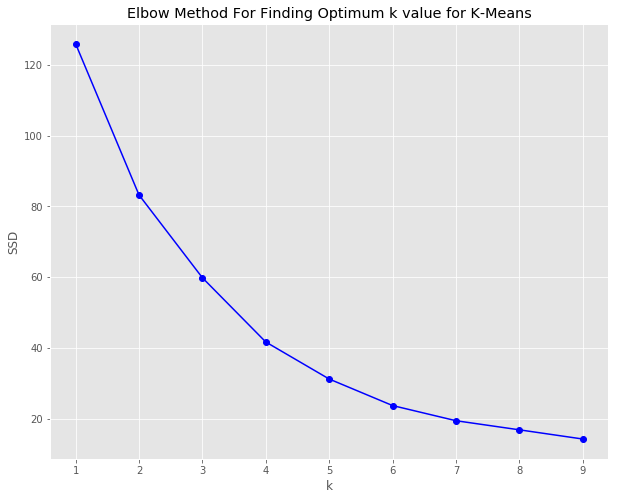

In [106]:
mpl.style.use(['ggplot'])
plt.figure(figsize=(10,8))
plt.plot(K, SSD, 'bo-')
plt.xlabel('k')
plt.ylabel('SSD')
plt.title('Elbow Method For Finding Optimum k value for K-Means')
        
plt.show()

No clear elbow point seems to exist in the plot above. Let's go ahead and cluster `cluster_dataset` with a total of 5 clusters:

In [107]:
def cluster_data(df, num_clusters, init, n_init, random_state, dataset):
    
    Kmeans = KMeans(n_clusters=num_clusters, init=init, n_init=n_init, random_state=random_state).fit(dataset)
    labels = Kmeans.labels_
    
    df['Labels'] = labels
    
    return df, Kmeans

In [108]:
Manhattan_df, Kmeans = cluster_data(Manhattan_df, 5, 'k-means++', 20, 0, cluster_dataset)

Let's insert the labels in the Manhattan_df dataframe:

In [109]:
New_Manhattan=Manhattan_Italian[['Neighborhood','Latitude','Longitude']]
Manhattan_df = Manhattan_df.merge(New_Manhattan, on='Neighborhood', how='inner')

In [110]:
Manhattan_df.head()

Neighborhood  Normalized Crime  Normalized Restaurants  \
0       Marble Hill          0.000000                0.000000   
1      Hudson Yards         11.993294               26.984912   
2  Roosevelt Island         60.061032                1.937453   
3   Stuyvesant Town        166.200596                1.100666   
4      Sutton Place        260.610810                4.009397   

   Normalized Italian  Labels           Latitude           Longitude  
0            0.000000       0  40.87595908670124  -73.91038412615494  
1            2.998324       3  40.75468718842502  -74.00323381629264  
2            0.000000       0  40.76190827590921   -73.9499424039314  
3            0.000000       0  40.73187017501964  -73.97664654410869  
4            0.000000       0    40.757041597784  -73.96186264540648

In [111]:
Manhattan_df.groupby('Labels').mean()

Normalized Crime  Normalized Restaurants  Normalized Italian
Labels                                                              
0             385.582651                3.327492            0.305014
1             926.856386               27.371612           11.078213
2            2038.876686                9.082820            0.727137
3             896.229453               34.160316            2.325325
4             978.366539               11.518041            1.868931

Based on the clusters above, neighborhoods with cluster label 0 seem to be the ideal neighborhoods to target for a starting Italian restaurant in Manhattan, since normalized crime, number of restaurants and number of Italian restaurants are the lowest among the other clusters:

Let's visualize the clusters:

In [112]:
def cluster_style(feature):
    return { 'color': 'blue', 'opacity':0.5, 'fill': True }

In [113]:
geolocator = Nominatim(user_agent='manhattan_NY')
location = geolocator.geocode('Manhattan, NY')
Man_lat = location.latitude
Man_lng = location.longitude

In [114]:
# set color scheme for the clusters
num_clusters = 5
x = np.arange(num_clusters)
ys = [i + x + (i*x)**2 for i in range(num_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

In [115]:
map_clusters = folium.Map(location= [Man_lat,Man_lng], tiles='Mapbox bright',zoom_start=13)
folium.TileLayer('CartoDB positron').add_to(map_clusters)
folium.GeoJson(Manhattan_neighbor,style_function=cluster_style, 
               name='geojson').add_to(map_clusters).add_child(folium.features.GeoJsonTooltip(fields=('name',),
                      aliases = ['Neighborhood'],
                      labels=True, 
                      sticky=True))

for lat, lon, neigh, cluster in zip(Manhattan_df['Latitude'], Manhattan_df['Longitude'], Manhattan_df['Neighborhood'],
                                    Manhattan_df['Labels']):
    label = folium.Popup(str(neigh) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10 if cluster==0 else 5,
        popup=label,
        color='navy' if cluster==0 else rainbow[cluster],
        fill=True,
        fill_color='navy' if cluster==0 else rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters

And finally, let's see which of the neighborhoods with label 1 are closest to the centroid center of cluster 1:

In [116]:
def center_dis(df, data, center, label):
    ind = df[df['Labels']==label].index.tolist()

    Center_dis = pd.DataFrame(columns=['Neighborhood','Distance'])
    for i in ind:
        dis= sum((data[i] - center[label-1])**2)
        Center_dis = Center_dis.append({'Neighborhood':Manhattan_df.loc[i,'Neighborhood'], 'Distance':dis},ignore_index=True)
        Center_dis.sort_values(by=['Distance'],inplace=True)
    return Center_dis

In [118]:
center_dis(Manhattan_df,cluster_dataset,Kmeans.cluster_centers_,0)

Neighborhood  Distance
0       Upper West Side  0.778000
1    Washington Heights  1.501239
2   Morningside Heights  1.663947
11          Two Bridges  1.797089
3          Civic Center  1.953576
4                Inwood  2.602418
5     Battery Park City  2.926163
6          Sutton Place  3.527633
7            Tudor City  3.669941
8       Stuyvesant Town  4.650768
9      Roosevelt Island  5.416148
10          Marble Hill  6.299975

Based on the `center_dis` dataframe on the distance of the value of each neighborhood from the cluster center, we can recommend top 5 locations as below:

1. **Upper West Side**
2. **Washington Heights**
3. **Morningside Heights**
4. **Two Bridges**
5. **Civis Center**


Let's visualize the neighborhoods in a plot as a function of normalized number of restaurants and normalized crime rates in each neighborhood. In the plot below, the size of each neighborhood mark is proportionate to the number of Normalized Italian Restaurants in that neighborhood. The neighborhoods with no blob marker don't have any Italian restaurants.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

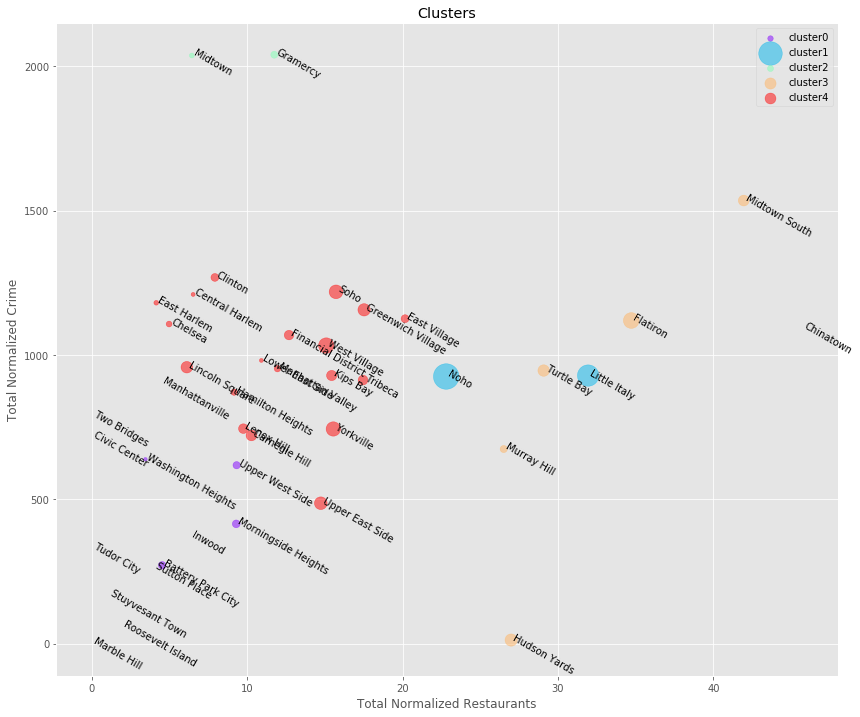

In [119]:
warnings.filterwarnings('ignore')

Colors = cm.rainbow(np.linspace(0, 1, num_clusters))
cluster_labels = list(range(0, num_clusters))

plt.figure(figsize=(14,12))

for Color, label in zip(Colors, cluster_labels):
    subset = Manhattan_df[Manhattan_df['Labels'] == label]
    for i in subset.index:
            plt.text(subset.loc[i,'Normalized Restaurants'], subset.loc[i,'Normalized Crime'],str(subset['Neighborhood'][i]), rotation=-30) 
    plt.scatter(subset['Normalized Restaurants'].values, subset['Normalized Crime'].values, s= (subset['Normalized Italian'].values)*50, c=Color, label='cluster'+str(label),alpha=0.5)
plt.legend()
plt.title('Clusters')
plt.xlabel('Total Normalized Restaurants')
plt.ylabel('Total Normalized Crime')

plt.savefig('manhattan_clusters_New.png')

If we ignore those neighborhoods with no restaurants in them, we'll end up with:

1. **Roosevelt Island**
2. **Stuyvesant Town**
2. **Sutton Place**
3. **Battery Park City**
4. **Inwood**